## Functions
- preprocessing
- predictions
- creating visualizations

### Not Needed for Web App

In [40]:
def basic_cleaning(review_df, sentiment_cutoff = 4,
                   text_col = 'review_text', rating_col = 'rating'):
    
    ## drop rows that don't contain any review text
    review_df = review_df[~review_df[text_col].isnull()].reset_index(drop=True)
    
    ## drop rows with improper rating
    review_df = review_df[review_df[rating_col].isin([5,4,3,2,1,'5','4','3','2','1'])]
    
    ## convert ratings to numeric (in case some are str)
    review_df[rating_col]= review_df[rating_col].astype(int) 
    
    ## add y column for sentiment classification. ratings > x are positive, <= are negative
    review_df['y'] = (review_df[rating_col] > sentiment_cutoff)
    
    ## remove unneccessary columns
    review_df = review_df.loc[:,['review_text','y']]
    
    return review_df

### Needed for Web App

In [7]:
from contractions import CONTRACTION_MAP
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import stop_words as sw_sklearn
from nltk.corpus import stopwords as sw_nltk
from gensim.parsing.preprocessing import STOPWORDS as sw_gensim

In [8]:
def sentence_splitter(reviews, split_on):
    sentences = [re.split(split_on,rev) for rev in reviews]
    sentences = [item.strip() for sublist in sentences for item in sublist]
    sentences = [sentence for sentence in sentences if sentence != '']
    return sentences

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def number_replacer(sentence):
    return re.sub('[A-Za-z]*[0-9]+[A-Za-z]*', 'numbertoken', sentence)

def tokenize_text(sentence):
    sentence = sentence.split(' ')
    return sentence

def alphanumerize(sentence, remove_pattern):
    removed = re.sub('<br>', '', sentence)
    removed = re.sub('&amp', '', removed) ## since the word 'amp' keeps showing up
    removed = re.sub('[Aa]\+', 'amazing', removed) ## A+ --> amazing
    removed = re.sub('thank you', 'thanks', removed) ## maybe remove this
    removed = re.sub(remove_pattern, '', removed)
    return removed

lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in text.split(' ')])

def remove_stopwords(sentence, stopwords):
    return ' '.join([word for word in sentence.split(' ') if word not in stopwords])

def get_w2v_features(w2v_model, sentence):
    
    index2word_set = set(w2v_model.wv.vocab.keys()) # create vocab set
    embedding = np.zeros(w2v_model.vector_size, dtype="float32") # init vector
    
    ## there shouldn't be empty sentences, but include this just in case
    if len(sentence) > 0:
        nwords = 0 # word counter
        for word in sentence:
            if word in index2word_set:
                # if the word is in the set, add it and increment counter
                embedding = np.add(embedding, w2v_model[word])
                nwords += 1.
        if nwords > 0: # in case no words were aded
            embedding = np.divide(embedding, nwords)
        
    return embedding

In [9]:
def preprocessing(review_df,
                  split_sentences = False,
                  replace_numbers = True,
                  tokenize = True,
                  lemmatize = True,
                  remove_stops = True,
                  embed = True,
                  output_embeddings = True,
                  split_on = "[\.!]+[ ]*",
                  stopwords = '',
                  remove_pattern = '[^0-9A-Za-z ]+',
                  W2Vmodel = '',
                  old_col='review_text',
                  new_col='clean_text'):
    
    ## other options...
    # replace rare words with a certain token
    
    ## split into sentences (optional)
    if split_sentences:
        print('splitting into sentences...')
        review_df = pd.DataFrame({old_col : sentence_splitter(review_df[old_col],split_on)})
    
    ## remove accents
    print('removing accents...')
    review_df[new_col] = list(map(remove_accented_chars, review_df[old_col]))
    
    ## convert all text to lowercase
    print('converting to lowercase...')
    review_df[new_col] = review_df[new_col].str.lower()
    
    ## expand contractions
    print('expanding contractions...')
    review_df[new_col] = list(map(expand_contractions,review_df[new_col]))
    
    ## replace numbers (optional)
    if replace_numbers:
        print('replacing numbers...')
        review_df[new_col] = list(map(number_replacer,review_df[new_col]))
    
    ## clear non-alphanumerics
    print('alphanumerizing...')
    review_df[new_col] = [alphanumerize(rev, remove_pattern) for rev in review_df[new_col]]
    
    ## lemmatize (optional)
    if lemmatize:
        print('lemmatizing...')
        review_df[new_col] = list(map(lemmatize_text,review_df[new_col]))
        
    ## remove stop words (optional)
    if remove_stops:
        print('removing stop words...')
        if stopwords == '':
            stopwords = nltk.corpus.stopwords.words('english')
            stopwords.remove('not')
        if lemmatize:
            stopwords = [lemmatizer.lemmatize(w) for w in stopwords]
        review_df[new_col] = [remove_stopwords(rev, stopwords) for rev in review_df[new_col]]

    ## tokenize (optional)
    if tokenize:
        print('tokenizing...')
        review_df[new_col] = list(map(tokenize_text,review_df[new_col]))
    
    ## embed (optional)
    if embed:
        print('embedding words...')
        review_df['embeddings'] = list(map(lambda sentence:get_w2v_features(W2Vmodel, sentence),
                                    review_df[new_col]))
        
        if output_embeddings:
            print('converting to embedded form...')
            review_df = review_df['embeddings'].apply(pd.Series)
    
    return review_df

In [10]:
def create_stopwords(my_stopwords):
    stopwords_sklearn = list(sw_sklearn.ENGLISH_STOP_WORDS)
    stopwords_nltk = list(sw_nltk.words('english'))
    stopwords_gensim = list(sw_gensim)

    custom_stopwords = set(stopwords_sklearn +
                           stopwords_nltk +
                           stopwords_gensim +
                           my_stopwords)
    
    return custom_stopwords

In [11]:
def similarity_test(rev, pool, vecs):
    similarity = 0
    for rev_word in rev:
        if rev_word in vecs:
            for pool_word in pool:
                if pool_word in vecs:
                    word_sim = vecs.similarity(rev_word,pool_word)
                    similarity = np.max([word_sim,similarity])
    return similarity

In [12]:
def topic_contribution(similarity):
    return round(np.min([np.max([similarity * 2 - 1, 0]),1]),2)

## Initial Setup (not part of web app)
- eda
- building / saving a model

### Read the data and preprocess

In [41]:
import numpy as np
import pandas as pd
import unicodedata
import re
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans
from sklearn.externals import joblib

In [42]:
data = pd.read_csv('review_data_200_sellers.csv')
#data = pd.read_csv('review_data_2800_sellers.csv')

In [43]:
data = basic_cleaning(data)

#### Set up initial W2V model

In [44]:
## process data to put into w2v model
data_for_w2v = preprocessing(data,
                             split_sentences=False,
                             remove_stops=False,
                             embed = False,
                             stopwords='')

removing accents...
converting to lowercase...
expanding contractions...
replacing numbers...
alphanumerizing...
lemmatizing...
tokenizing...


In [45]:
%%time

#### set up and train the w2v model
### I think this is a spot that could be improved...
# how does it decide which words to include? is it starting from pretrained?

# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 10   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=data_for_w2v['clean_text'],
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

CPU times: user 42.7 s, sys: 30.5 ms, total: 42.7 s
Wall time: 11 s


In [46]:
## this was an attempt to initialize from pretrained embeddings
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove_input_file = 'glove.twitter.27B.50d.txt'
# word2vec_output_file = 'word2vec.twitter.27B.50d.txt'
# glove2word2vec(glove_input_file, word2vec_output_file)
# from gensim.models import KeyedVectors
# model = KeyedVectors.load_word2vec_format("word2vec.twitter.27B.50d.txt", binary=False)
# model_2 = Word2Vec(size=300, min_count=1)
# model_2.build_vocab(sentences=data_for_w2v['clean_text'])
# total_examples = model_2.corpus_count
# model_2.build_vocab([list(model.vocab.keys())], update=True)
# model_2.intersect_word2vec_format("word2vec.twitter.27B.50d.txt", binary=False, lockf=1.0)
# model_2.train(sentences, total_examples=total_examples, epochs=model_2.iter)

#### Create cluster model to identify non-english

In [47]:
## process the data for the language model
data_for_language = preprocessing(data,
                                  split_sentences = False,
                                  replace_numbers = True,
                                  tokenize = True,
                                  lemmatize = True,
                                  remove_stops = False,
                                  embed = True,
                                  output_embeddings = True,
                                  W2Vmodel = W2Vmodel)

removing accents...
converting to lowercase...
expanding contractions...
replacing numbers...
alphanumerizing...
lemmatizing...
tokenizing...
embedding words...


/home/michael/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


converting to embedded form...


In [48]:
## train the clustering model on 2 clusters (english vs non-english)
#kmeans_vecs_2 = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto')
#kmeans_vecs_2.fit(data_for_language)

## dump the model
#joblib.dump(kmeans_vecs_2, 'kmeans_for_language.pkl')
kmeans_vecs_2 = open('kmeans_for_language.pkl','rb')
kmeans_vecs_2 = joblib.load(kmeans_vecs_2)

In [49]:
## confirm that it worked & identify the 
data_transformed = kmeans_vecs_2.predict(data_for_language)
data.review_text[data_transformed == 0][:5]

Series([], Name: review_text, dtype: object)

In [50]:
## create an english-only dataset
data_english = data[data_transformed == 1]

#### Retrain the W2V Model on english only

In [51]:
## process data to put into w2v model
data_for_w2v = preprocessing(data,
                             split_sentences=False,
                             remove_stops=False,
                             embed = False,
                             stopwords='')

removing accents...
converting to lowercase...
expanding contractions...
replacing numbers...
alphanumerizing...
lemmatizing...
tokenizing...


In [52]:
# Initialize and train the model
# W2Vmodel = Word2Vec(sentences=data_for_w2v['clean_text'],
#                     sg=1,
#                     hs=0,
#                     workers=num_workers,
#                     size=num_features,
#                     min_count=min_word_count,
#                     window=context,
#                     sample=downsampling,
#                     negative=5,
#                     iter=6)

#joblib.dump(kmeans_vecs_2, 'kmeans_for_language.pkl')
W2Vmodel = open('W2Vmodel.pkl','rb')
W2Vmodel = joblib.load(W2Vmodel)

#### Topic Clustering (or, just some code to measure similarity?)

In [53]:
## write this to another file.
stopwords_mike = ['bracelets','necklace','earrings',
                 'bracelet','ring','daughter','mother',
                 'anklet','cindy','gift','gorgeous',
                 'item','product','color','colors',
                 'lovely','perfect','cute','beautiful','great',
                  'super','order','wonderful','work','awesome',
                 'loved','lt','pretty','little','love','absolutely',
                 'bunch','wear','friend','piece','amazing','happy',
                  'fantastic','xx','summer','excellent','million',
                 'michael','lisa','good','looks','highly','recommend',
                 'price','leather','future','pleased','high','beads',
                  'you','nice','size','looking',
                 'design','buy','definitely','fast','quickly',
                 'products','product','promptly','quickly','quick',
                 'numbertoken','like','ordered','fit','purchase','bought',
                  'christmas','beautifully','perfectly','purchased','husband',
                  'ordering','adorable','way','small','better','wrist',
                  'jewelry','wearing','day','wanted', 'easy', 'new','lot',
                  'best','going', 'custom','sure', 'simple','right','person',
                  'boyfriend','took', 'charm', 'sent', 'photo', 'week','use',
                  'birthday','son','extra','bit','favorite', 'clasp','present',
                  'nose','bag','sister','chain','mom', 'year', 'stone','wedding',
                  'thought','delicate','feel','gave', 'different','dainty',
                  'box','big','second','blanket','sweet','comfortable',
                  'thing','extremely','baby','silver','want']

In [54]:
custom_stopwords = create_stopwords(stopwords_mike)

In [55]:
data_for_clustering = preprocessing(data_english,
                                    split_sentences=True,
                                    embed=True,
                                    output_embeddings=True,
                                    W2Vmodel = W2Vmodel,
                                    stopwords=custom_stopwords)

splitting into sentences...
removing accents...
converting to lowercase...
expanding contractions...
replacing numbers...
alphanumerizing...
lemmatizing...
removing stop words...
tokenizing...
embedding words...


/home/michael/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


converting to embedded form...


In [56]:
## clustering goes here

#### Back-up Word Lists

In [57]:
# put this into a separate file

uniqueness_pool = ['unique', 'creative', 'special',
                   'inventive', 'innovative', 'handmade',
                   'original', 'handcrafted',
                   'creativity', 'crafted','made']

humantouch_pool = ['helpful', 'communication', 'response',
                   'respond', 'contact', 'friendly',
                   'attentive', 'accommodating', 'courteous',
                   'polite', 'respect', 'pleasant',
                   'service','kind','personal','seller',
                   'personable','interaction','reply','answer',
                   'honest']
# this will hit on other types of interaction
# future - different types of human touch (e.g. responsiveness, personalization, etc)
# need to train my word vectors on more negative reviews (use pre-trained vectors to get negative words)
# also, problem of having positive words in my topics

quality_pool = ['quality', 'condition', 'described',
                'detailed', 'craftmanship', 'craftsmanship',
                'detail', 'workmanship', 'material']

In [58]:
review = ['service','trustworthy','honest','seller']

In [59]:
topic_contribution(similarity_test(review,
                                   humantouch_pool,
                                   W2Vmodel.wv))

1.0

In [60]:
## this was an abandoned way to classify the topic

# uniqueness_vector = np.zeros(200)
# n_words = 0
# for word in uniqueness_pool:
#     if word in word_vectors:
#         n_words += 1
#         uniqueness_vector += word_vectors[word]
# uniqueness_vector = uniqueness_vector / n_words
# print('words: ' + str(n_words))
# word_vectors.most_similar([uniqueness_vector])

# humantouch_vector = np.zeros(200)
# n_words = 0
# for word in humantouch_pool:
#     if word in word_vectors:
#         n_words += 1
#         humantouch_vector += word_vectors[word]
# humantouch_vector = humantouch_vector / n_words
# print('words: ' + str(n_words))
# word_vectors.most_similar([humantouch_vector])

# quality_vector = np.zeros(200)
# n_words = 0
# for word in quality_pool:
#     if word in word_vectors:
#         n_words += 1
#         quality_vector += word_vectors[word]
# quality_vector = quality_vector / n_words
# print('words: ' + str(n_words))
# word_vectors.most_similar([quality_vector])

### Sentiment Model

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler # why this one?

In [62]:
## process the data for the sentiment model
data_for_sentiment = preprocessing(data,
                                   split_sentences = False,
                                   replace_numbers = True,
                                   tokenize = False,
                                   lemmatize = True,
                                   remove_stops = False,
                                   embed = False)

removing accents...
converting to lowercase...
expanding contractions...
replacing numbers...
alphanumerizing...
lemmatizing...


In [63]:
###### but for the actual model I want to train this on thentire dataset!
## training and validation set
X_train, X_test, y_train, y_test = train_test_split(data_for_sentiment['clean_text'],
                                                    data_for_sentiment['y'],
                                                    test_size=0.25,
                                                    random_state=20313119)

In [115]:
## oversampling
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train.to_frame(), y_train)
X_resampled = pd.Series(X_resampled[:,0]); y_resampled = pd.Series(y_resampled)

In [116]:
model_nb = make_pipeline(TfidfVectorizer(ngram_range = (1,2)),
                         MultinomialNB())

#model_nb.fit(X_resampled, y_resampled)
#joblib.dump(model_nb, 'model_nb_200sellers.pkl')
model_nb = open('model_nb_200sellers.pkl','rb')
model_nb = joblib.load(model_nb)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [117]:
yhat_train = model_nb.predict(X_train)
yhat_test = model_nb.predict(X_test)

In [118]:
df_confusion = pd.crosstab(pd.Series(y_test.reset_index(drop=True),name='Actual'),
                           pd.Series(yhat_test,name='Predicted'))
precision_test = df_confusion.loc[True,True] / np.sum(df_confusion.loc[:,True])
print(precision_test)
df_confusion

0.9026732216930404


Predicted,False,True
Actual,,
False,239,1267
True,2187,11751


In [68]:
y_train_proba = model_nb.predict_proba(X_train)
y_test_proba = model_nb.predict_proba(X_test)

## Code for Web App
- putting the functions together for the ap

In [69]:
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import unicodedata
import re

In [70]:
app_input = "The seller was very mean and rude. I will definitely not buy anything from them again, even the though product was very high quality."

In [71]:
W2Vmodel = joblib.load(open('W2Vmodel.pkl','rb'))

In [72]:
model_nb = joblib.load(open('model_nb_200sellers.pkl','rb'))

### Topic Classification

In [73]:
stopwords_mike = ['bracelets','necklace','earrings',
                 'bracelet','ring','daughter','mother',
                 'anklet','cindy','gift','gorgeous',
                 'item','product','color','colors',
                 'lovely','perfect','cute','beautiful','great',
                  'super','order','wonderful','work','awesome',
                 'loved','lt','pretty','little','love','absolutely',
                 'bunch','wear','friend','piece','amazing','happy',
                  'fantastic','xx','summer','excellent','million',
                 'michael','lisa','good','looks','highly','recommend',
                 'price','leather','future','pleased','high','beads',
                  'you','nice','size','looking',
                 'design','buy','definitely','fast','quickly',
                 'products','product','promptly','quickly','quick',
                 'numbertoken','like','ordered','fit','purchase','bought',
                  'christmas','beautifully','perfectly','purchased','husband',
                  'ordering','adorable','way','small','better','wrist',
                  'jewelry','wearing','day','wanted', 'easy', 'new','lot',
                  'best','going', 'custom','sure', 'simple','right','person',
                  'boyfriend','took', 'charm', 'sent', 'photo', 'week','use',
                  'birthday','son','extra','bit','favorite', 'clasp','present',
                  'nose','bag','sister','chain','mom', 'year', 'stone','wedding',
                  'thought','delicate','feel','gave', 'different','dainty',
                  'box','big','second','blanket','sweet','comfortable',
                  'thing','extremely','baby','silver','want']

uniqueness_pool = ['unique', 'creative', 'special',
                   'inventive', 'innovative', 'handmade',
                   'original', 'handcrafted',
                   'creativity', 'crafted','made']

humantouch_pool = ['helpful', 'communication', 'response',
                   'respond', 'contact', 'friendly',
                   'attentive', 'accommodating', 'courteous',
                   'polite', 'respect', 'pleasant',
                   'service','kind','personal',
                   'personable','interaction','reply','answer',
                   'honest','rude','unhelpful','unresponsive',
                  'personalised','personalized']

quality_pool = ['quality', 'condition', 'described',
                'detailed', 'craftmanship', 'craftsmanship',
                'detail', 'workmanship', 'material','broke','break',
               'fell','apart']

## for positive words in the word pools, also include synonyms

In [74]:
custom_stopwords = create_stopwords(stopwords_mike)

In [75]:
app_input_df = pd.DataFrame({'review_text' : [app_input]})

In [76]:
input_data_for_topic = preprocessing(app_input_df,
                                     split_sentences = True,
                                     replace_numbers = True,
                                     tokenize = True,
                                     lemmatize = True,
                                     remove_stops = True,
                                     embed = False,
                                     split_on = "[\.!,]+[ ]*",
                                     stopwords = custom_stopwords)

splitting into sentences...
removing accents...
converting to lowercase...
expanding contractions...
replacing numbers...
alphanumerizing...
lemmatizing...
removing stop words...
tokenizing...


In [77]:
input_data_for_topic

,review_text,clean_text
0,The seller was very mean and rude,"[seller, mean, rude]"
1,I will definitely not buy anything from them a...,[]
2,even the though product was very high quality,[quality]


In [78]:
sentences = input_data_for_topic['clean_text']

In [79]:
uniqueness_sims = [similarity_test(r, uniqueness_pool, W2Vmodel.wv) for r in sentences]
humantouch_sims = [similarity_test(r, humantouch_pool, W2Vmodel.wv) for r in sentences]
quality_sims = [similarity_test(r, quality_pool, W2Vmodel.wv) for r in sentences]

In [80]:
uniqueness_conts = [topic_contribution(sim) for sim in uniqueness_sims]
humantouch_conts = [topic_contribution(sim) for sim in humantouch_sims]
quality_conts = [topic_contribution(sim) for sim in quality_sims]

### Sentiment Analysis

In [81]:
## process the data for the sentiment model
data_for_sentiment = preprocessing(app_input_df,
                                   split_sentences = True,
                                   replace_numbers = True,
                                   tokenize = False,
                                   lemmatize = True,
                                   remove_stops = False,
                                   split_on = "[\.!,]+[ ]*",
                                   embed = False)

splitting into sentences...
removing accents...
converting to lowercase...
expanding contractions...
replacing numbers...
alphanumerizing...
lemmatizing...


In [82]:
data_for_sentiment['clean_text']

0                     the seller wa very mean and rude
1    i will definitely not buy anything from them a...
2         even the though product wa very high quality
Name: clean_text, dtype: object

In [83]:
sentiments = model_nb.predict_proba(data_for_sentiment['clean_text'])[:,1]

In [84]:
sentiments = sentiments * 2 - 1

In [85]:
sentiments

array([-0.74145284, -0.48133702,  0.37105345])

### Create Score Using Topic Classification and Sentiment Analysis

In [86]:
uniqueness_score = np.sum(np.multiply(sentiments,uniqueness_conts))
humantouch_score = np.sum(np.multiply(sentiments,humantouch_conts))
quality_score = np.sum(np.multiply(sentiments,quality_conts))

In [87]:
app_input

'The seller was very mean and rude. I will definitely not buy anything from them again, even the though product was very high quality.'

In [88]:
sentiments

array([-0.74145284, -0.48133702,  0.37105345])

In [89]:
uniqueness_score,humantouch_score,quality_score

(0.007427609650846983, -0.7340317757445779, 0.30432269643820997)

In [90]:
uniqueness_conts,humantouch_conts,quality_conts

([0.01, 0.0, 0.04], [1.0, 0.0, 0.02], [0.09, 0.0, 1.0])

In [91]:
uniqueness_conts

[0.01, 0.0, 0.04]

In [92]:
sentiments

array([-0.74145284, -0.48133702,  0.37105345])

## Distribution of Training

In [93]:
sample_data = data_english.sample(1000)

In [94]:
training_topic = preprocessing(sample_data,
                               split_sentences = False,
                               replace_numbers = True,
                               tokenize = True,
                               lemmatize = True,
                               remove_stops = True,
                               embed = False,
                               stopwords = custom_stopwords)

removing accents...
converting to lowercase...
expanding contractions...
replacing numbers...
alphanumerizing...
lemmatizing...
removing stop words...
tokenizing...


In [95]:
training_topic.head()

,review_text,y,clean_text,embeddings
13345,Friend loves it. Thanks!,True,[thanks],"[-0.056631826, 0.20809911, 0.05880275, 0.10198..."
27748,Perfect item once again. A special gift for my...,True,"[special, hubby, thanks, x]","[0.049947638, 0.15428157, -0.053624954, -0.065..."
33198,This is part of a larger order; and like the p...,True,"[larger, previous, posting, priced, , service]","[0.09703035, 0.21476015, -0.10617811, 0.110089..."
18918,I love this so much I want another color. It ...,True,"[, exactly, picture, expected, , ok, shipping,...","[0.08016536, 0.19877307, 0.027579254, 0.058497..."
10494,Great shop to buy snap charms,True,"[shop, snap]","[0.26379707, 0.23107846, -0.041005164, 0.14764..."


In [96]:
sentences = training_topic['clean_text']

In [97]:
uniqueness_sims = [similarity_test(r, uniqueness_pool, W2Vmodel.wv) for r in sentences]
humantouch_sims = [similarity_test(r, humantouch_pool, W2Vmodel.wv) for r in sentences]
quality_sims = [similarity_test(r, quality_pool, W2Vmodel.wv) for r in sentences]

In [98]:
uniqueness_conts = [topic_contribution(sim) for sim in uniqueness_sims]
humantouch_conts = [topic_contribution(sim) for sim in humantouch_sims]
quality_conts = [topic_contribution(sim) for sim in quality_sims]

In [99]:
training_sentiment = preprocessing(sample_data,
                                   split_sentences = False,
                                   replace_numbers = True,
                                   tokenize = False,
                                   lemmatize = True,
                                   remove_stops = False,
                                   embed = False)

removing accents...
converting to lowercase...
expanding contractions...
replacing numbers...
alphanumerizing...
lemmatizing...


In [100]:
sentiments = model_nb.predict_proba(training_sentiment['clean_text'])[:,1]

In [101]:
sentiments = sentiments * 2 - 1

In [102]:
uniqueness_scores = np.multiply(sentiments, uniqueness_conts)
humantouch_score = np.multiply(sentiments, humantouch_conts)
quality_score = np.multiply(sentiments, quality_conts)

In [103]:
training_sentiment = pd.DataFrame({'uniqueness' : uniqueness_scores,
                                  'humantouch' : humantouch_score,
                                  'quality' : quality_score})

In [104]:
training_sentiment.head()

,uniqueness,humantouch,quality
0,0.000000,0.000000,0.031130
1,0.954465,0.229072,0.066813
2,0.288799,0.687616,0.213161
3,0.000000,0.037318,0.037318
4,0.000000,0.009540,0.000000


In [105]:
training_sentiment.to_csv('training_sentiment.csv',index=False)

In [106]:
training_sentiment = pd.read_csv('training_sentiment.csv')

In [107]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set

<function seaborn.rcmod.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)>

([], <a list of 0 Text yticklabel objects>)

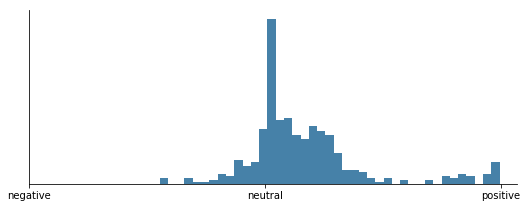

In [108]:
probdata = pd.Series(training_sentiment.uniqueness, name = "Sentiment")
plotdata = probdata[probdata != 0]
g = sns.FacetGrid(plotdata, height = 3, aspect = 2.5)
g = plt.hist(plotdata, bins=41, color='#4681a8')
y, x, _ = g
plt.xticks(np.array([-1,0,1]),['negative','neutral','positive'])
plt.yticks([])

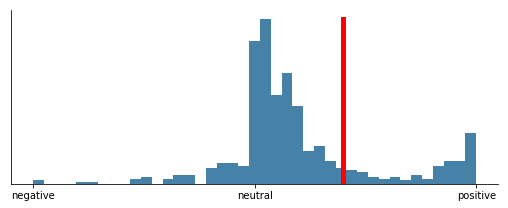

In [109]:
probdata = pd.Series(training_sentiment.humantouch, name = "Sentiment")
plotdata = probdata[probdata != 0]
g = sns.FacetGrid(plotdata, height = 3, aspect = 2.5)
g = plt.hist(plotdata, bins=41, color='#4681a8')
y, x, _ = g
plt.xticks(np.array([-1,0,1]),['negative','neutral','positive'])
plt.yticks([])
X_plot = np.array([0.4,0.4]); Y_plot = np.array([0,y.max()])
plt.plot(X_plot, Y_plot, color='r', linewidth=5)

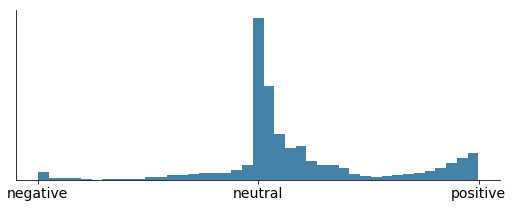

In [467]:
probdata = pd.Series(training_sentiment.quality, name = "Sentiment")
plotdata = probdata[probdata != 0]
g = sns.FacetGrid(plotdata, height = 3, aspect = 2.5)
g = plt.hist(plotdata, bins=41, color='#4681a8')
y, x, _ = g
plt.xticks(np.array([-1,0,1]),['negative','neutral','positive'])
plt.yticks([])
plt.rc('xtick', labelsize=14) 